# Batch Helpers

Notebook cells to help:
- manage your results for motion correction and segmentation.
- remove results from a dataframe 
- correct filenames
- convert intermediate .mmemap to other filetypes
- rechunk outputs for faster file access

In [3]:
import os
import logging
from pathlib import Path
import lbm_caiman_python as lcp

import dask.array as da
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zarr

import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
from caiman.source_extraction.cnmf import cnmf, params

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

# set up logging
debug = True

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

if debug:
   logging.getLogger("caiman").setLevel(logging.WARNING)

## Manage batch and dataframe filepath locations

In [5]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'  # where the output files from the assembly step are located
batch_path = data_path / 'batch.pickle'

mc.set_parent_raw_data_path(data_path)

df=mc.load_batch(batch_path)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",{'mean-projection-path': 2bfd5a28-202a-426d-b74b-02105ea885a5\2bfd5a28-202a-426d-b74b-02105ea885a5_mean_projection.n...,2024-12-06T10:59:47,2024-12-06T11:01:36,105.4 sec,None,2bfd5a28-202a-426d-b74b-02105ea885a5
1,mcorr,plane_1.tiff,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,064f4b03-678f-4bdd-af1c-c0ac9cc62650
2,mcorr,plane_11.tiff,plane_11.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,63dd8cb1-9cba-4e0f-9931-ec401cbcb07b
3,mcorr,plane_12.tiff,plane_12.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,a1507467-fe53-492c-8975-fb09d871706a
4,mcorr,plane_13.tiff,plane_13.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,95e49c3b-4bf0-4dff-9eff-9e7727ed5692
5,mcorr,plane_14.tiff,plane_14.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,bd6f420f-8c9f-441e-ae32-82e1fbfbb6c0
6,mcorr,plane_15.tiff,plane_15.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,2ffac9e6-1ff0-4525-8040-549b578af49b
7,mcorr,plane_16.tiff,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,5256d5b0-29bb-46df-9410-6a4e56811f01
8,mcorr,plane_17.tiff,plane_17.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,b837754b-0174-4511-a16a-3804c532aa83
9,mcorr,plane_18.tiff,plane_18.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",None,2024-12-06T12:04:14,None,None,None,919f7d1a-7e4c-4c8e-aec0-575168504704


## Remove rows with no output (accidental entries)

In [6]:
for i, row in df.iterrows():
    if row['outputs'] is None:
        df.caiman.remove_item(row.uuid)

df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...",{'mean-projection-path': 2bfd5a28-202a-426d-b74b-02105ea885a5\2bfd5a28-202a-426d-b74b-02105ea885a5_mean_projection.n...,2024-12-06T10:59:47,2024-12-06T11:01:36,105.4 sec,None,2bfd5a28-202a-426d-b74b-02105ea885a5


## Selectively remove rows by index

In [27]:
good_rows = np.arange(0, 31)
good_rows

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
# good_rows = np.concatenate(([0, 1], np.arange(2, 30)))
# good_rows = [0, 1, 2]

rows_keep = [df.iloc[n].uuid for n in good_rows]
for i, row in df.iterrows():
    if row.uuid not in rows_keep:
        df.caiman.remove_item(row.uuid)

df = df.caiman.reload_from_disk()
df

## Add a `comment`

In [13]:
comment_row = 0

## Add comments to dataframe
df.iloc[comment_row].comments = "Motion correction round 1!"
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...,2024-09-26T11:56:54,2024-09-26T12:02:55,77.3 sec,Motion correction round 1!,b32f41bf-a9a5-4965-be7c-e6779e854328
1,cnmf,cnmf_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': a057e39e-a2df-41d3-8217-83c9cd7ffb6d\a057e39e-a2df-41d3-8217-83c9cd7ffb6d_mean_projection.n...,2024-09-26T16:26:20,2024-09-26T16:28:48,143.18 sec,None,a057e39e-a2df-41d3-8217-83c9cd7ffb6d
2,cnmf,extracted_plane_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': 5cb543ec-5358-4b35-83cf-bfd19fa06a68\5cb543ec-5358-4b35-83cf-bfd19fa06a68_mean_projection.n...,2024-09-27T14:48:59,2024-09-27T14:50:30,80.14 sec,None,5cb543ec-5358-4b35-83cf-bfd19fa06a68
3,cnmf,extracted_plane_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': df52a609-d986-4bc0-a0a2-526cbfda057d\df52a609-d986-4bc0-a0a2-526cbfda057d_mean_projection.n...,2024-09-27T14:48:59,2024-09-27T14:51:46,75.93 sec,None,df52a609-d986-4bc0-a0a2-526cbfda057d
4,cnmf,extracted_plane_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': b68a8efe-1a3b-4392-b6e7-416312f1f945\b68a8efe-1a3b-4392-b6e7-416312f1f945_mean_projection.n...,2024-09-27T14:48:59,2024-09-30T10:30:15,96.62 sec,None,b68a8efe-1a3b-4392-b6e7-416312f1f945
5,cnmf,extracted_plane_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': 15e6fb81-fac4-457b-96da-dbb8e2d7b669\15e6fb81-fac4-457b-96da-dbb8e2d7b669_mean_projection.n...,2024-09-27T14:48:59,2024-09-30T10:20:28,109.54 sec,None,15e6fb81-fac4-457b-96da-dbb8e2d7b669


## Change the `item_name`

In [ ]:
comment_row = 0

## Add comments to dataframe
df.iloc[comment_row].item_name = "Motion correction round 1!"
df

## Change/correct `input_movie_path`

- for example, add .zarr ext to directory for caiman compatibility

In [ ]:
## Correct filenames
for idx, row in df.iterrows():
    row.input_movie_path = Path(row.input_movie_path).with_suffix('.zarr')
df.caiman.save_to_disk()

# Convert intermediate `.mmmap` to `.zarr`

TODO: Move these to a separate 'helpers' notebook as they aren't related specifically to batch management

In [8]:
res_path = movie_path.parent / 'registered'
res_path.mkdir(exist_ok=True)
store = zarr.open_like(mcorr_movie, path=res_path, mode='a',)  # read/write, create if it doesnt exist
store[:] = mcorr_movie

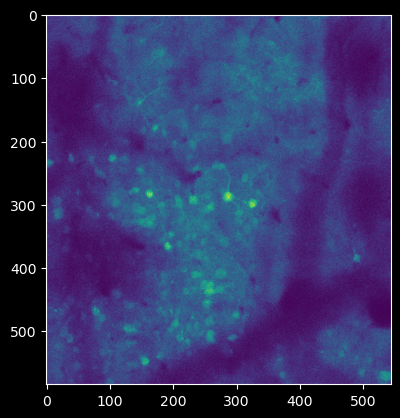

In [10]:
plt.imshow(store[1, :,:])

# Rechunk outputs for fast frame access (view movies)

In [17]:
rechunked = da.rechunk(da.from_zarr(store), {0: 'auto', 1: -1, 2: -1}, block_size_limit=1e8)